In [1]:
import pyspark

In [2]:
from pyspark import SparkContext, SparkConf

conf = SparkConf()
conf.setMaster("local[2]")
#conf.setMaster("spark://193.205.92.86:7077")
conf.setAppName("CountingSheep")
conf.set("spark.driver.bindAddress", "127.0.0.1")
sc = SparkContext(conf=conf)

#sc = SparkContext("local", "Sentimentanalysis")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/10 16:38:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("IoTBatchAnalytics").getOrCreate()

'''
df = spark.read \
    .option("header", True) \
    .option("inferSchema", True) \
    .csv("iot_dipme_data.csv")

df.printSchema()
df.show(5, truncate=False)
'''

'\ndf = spark.read     .option("header", True)     .option("inferSchema", True)     .csv("iot_dipme_data.csv")\n\ndf.printSchema()\ndf.show(5, truncate=False)\n'

In [4]:
from pyspark.sql.types import *

schema = StructType([
    StructField("@timestamp", StringType(), True),
    StructField("panid", IntegerType(), True),
    StructField("sensorid", StringType(), True),
    StructField("mqtt.topic", StringType(), True),
    StructField("sensorType", StringType(), True),
    StructField("presence", StringType(), True),
    StructField("tenant", StringType(), True),
    StructField("battery_value", FloatType(), True),
    StructField("device_type", StringType(), True),
    StructField("c02", FloatType(), True),
    StructField("device_name", StringType(), True),
    StructField("humidity", FloatType(), True),
    StructField("sensorid2", StringType(), True),
    StructField("installation_id", StringType(), True),
    StructField("last_presence", IntegerType(), True),
    StructField("pressure", FloatType(), True),
    StructField("temperature", FloatType(), True),
    StructField("tz", StringType(), True),
    StructField("uuid", StringType(), True),
    StructField("people_count", IntegerType(), True),
    StructField("people_entered", IntegerType(), True),
    StructField("people_exited", IntegerType(), True)
])

In [5]:
df = spark.read \
    .option("header", True) \
    .schema(schema) \
    .csv("iot_dipme_data.csv")

df.printSchema()

root
 |-- @timestamp: string (nullable = true)
 |-- panid: integer (nullable = true)
 |-- sensorid: string (nullable = true)
 |-- mqtt.topic: string (nullable = true)
 |-- sensorType: string (nullable = true)
 |-- presence: string (nullable = true)
 |-- tenant: string (nullable = true)
 |-- battery_value: float (nullable = true)
 |-- device_type: string (nullable = true)
 |-- c02: float (nullable = true)
 |-- device_name: string (nullable = true)
 |-- humidity: float (nullable = true)
 |-- sensorid2: string (nullable = true)
 |-- installation_id: string (nullable = true)
 |-- last_presence: integer (nullable = true)
 |-- pressure: float (nullable = true)
 |-- temperature: float (nullable = true)
 |-- tz: string (nullable = true)
 |-- uuid: string (nullable = true)
 |-- people_count: integer (nullable = true)
 |-- people_entered: integer (nullable = true)
 |-- people_exited: integer (nullable = true)



In [43]:
df.show(5, truncate=False)

+--------------------------+-----+--------+-----------+-------+-------------+-----------+-----+-----------+--------+---------+---------------+-------------+--------+-----------+------------------------------------+------------+--------------+-------------+-----------------------+--------+
|@timestamp                |panid|sensorid|sensorType |tenant |battery_value|device_type|c02  |device_name|humidity|sensorid2|installation_id|last_presence|pressure|temperature|uuid                                |people_count|people_entered|people_exited|tz                     |presence|
+--------------------------+-----+--------+-----------+-------+-------------+-----------+-----+-----------+--------+---------+---------------+-------------+--------+-----------+------------------------------------+------------+--------------+-------------+-----------------------+--------+
|Dec 9, 2025 @ 02:19:25.496|4150 |06      |multisensor|sacconi|3.11         |-          |321.0|-          |37.725  |-        |ap  

In [7]:
df.count()

25762

In [38]:
from pyspark.sql.functions import when, lower, col

df = df.withColumn(
    "presence_int",
    when(lower(col("presence")) == "true", 1)
    .when(lower(col("presence")) == "false", 0)
    .otherwise(None)
)

df.select("presence", "presence_int").show(3)
df = df.drop("presence").withColumnRenamed("presence_int", "presence")

+--------+------------+
|presence|presence_int|
+--------+------------+
|       0|        NULL|
|       0|        NULL|
|       0|        NULL|
+--------+------------+
only showing top 3 rows



In [9]:
from pyspark.sql.functions import to_timestamp
import datetime


In [10]:
import datetime

# 3. Conversione della stringa in timestamp
date_format = "MMM d, yyyy @ HH:mm:ss.SSS"

df = df.withColumn(
    "tz_date",
    to_timestamp(df["tz"], date_format)
)

# 4. Visualizzazione del risultato e dello schema
df.printSchema()
df.select(['sensorid', 'tz', 'tz_date']).show(10, truncate=False)
df = df.drop("tz").withColumnRenamed("tz_date", "tz")

root
 |-- @timestamp: string (nullable = true)
 |-- panid: integer (nullable = true)
 |-- sensorid: string (nullable = true)
 |-- mqtt.topic: string (nullable = true)
 |-- sensorType: string (nullable = true)
 |-- tenant: string (nullable = true)
 |-- battery_value: float (nullable = true)
 |-- device_type: string (nullable = true)
 |-- c02: float (nullable = true)
 |-- device_name: string (nullable = true)
 |-- humidity: float (nullable = true)
 |-- sensorid2: string (nullable = true)
 |-- installation_id: string (nullable = true)
 |-- last_presence: integer (nullable = true)
 |-- pressure: float (nullable = true)
 |-- temperature: float (nullable = true)
 |-- tz: string (nullable = true)
 |-- uuid: string (nullable = true)
 |-- people_count: integer (nullable = true)
 |-- people_entered: integer (nullable = true)
 |-- people_exited: integer (nullable = true)
 |-- presence: integer (nullable = true)
 |-- tz_date: timestamp (nullable = true)

+--------+--------------------------+------

In [36]:
df.select(["sensorid", "`mqtt.topic`"]).show(10, truncate=False)



AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `mqtt.topic` cannot be resolved. Did you mean one of the following? [`sensorid`, `panid`, `sensorid2`, `tenant`, `tz`].;
'Project [sensorid#2, '`mqtt.topic`]
+- Project [@timestamp#0, panid#1, sensorid#2, sensorType#4, tenant#6, battery_value#7, device_type#8, c02#9, device_name#10, humidity#11, sensorid2#12, installation_id#13, last_presence#14, pressure#15, temperature#16, uuid#18, people_count#19, people_entered#20, people_exited#21, presence#241, tz#328]
   +- Deduplicate [device_name#10, @timestamp#0, sensorid#2, installation_id#13, pressure#15, battery_value#7, tenant#6, people_exited#21, uuid#18, mqtt.topic#3, tz#328, temperature#16, last_presence#14, device_type#8, sensorid2#12, humidity#11, presence#241, people_count#19, panid#1, sensorType#4, c02#9, people_entered#20]
      +- Deduplicate [device_name#10, @timestamp#0, sensorid#2, installation_id#13, pressure#15, battery_value#7, tenant#6, people_exited#21, uuid#18, mqtt.topic#3, tz#328, temperature#16, last_presence#14, device_type#8, sensorid2#12, humidity#11, presence#241, people_count#19, panid#1, sensorType#4, c02#9, people_entered#20]
         +- Deduplicate [device_name#10, @timestamp#0, sensorid#2, installation_id#13, pressure#15, battery_value#7, tenant#6, people_exited#21, uuid#18, mqtt.topic#3, tz#328, temperature#16, last_presence#14, device_type#8, sensorid2#12, humidity#11, presence#241, people_count#19, panid#1, sensorType#4, c02#9, people_entered#20]
            +- Project [@timestamp#0, panid#1, sensorid#2, mqtt.topic#3, sensorType#4, tenant#6, battery_value#7, device_type#8, c02#9, device_name#10, humidity#11, sensorid2#12, installation_id#13, last_presence#14, pressure#15, temperature#16, uuid#18, people_count#19, people_entered#20, people_exited#21, presence#241, tz_date#264 AS tz#328]
               +- Project [@timestamp#0, panid#1, sensorid#2, mqtt.topic#3, sensorType#4, tenant#6, battery_value#7, device_type#8, c02#9, device_name#10, humidity#11, sensorid2#12, installation_id#13, last_presence#14, pressure#15, temperature#16, uuid#18, people_count#19, people_entered#20, people_exited#21, presence#241, tz_date#264]
                  +- Project [@timestamp#0, panid#1, sensorid#2, mqtt.topic#3, sensorType#4, tenant#6, battery_value#7, device_type#8, c02#9, device_name#10, humidity#11, sensorid2#12, installation_id#13, last_presence#14, pressure#15, temperature#16, tz#17, uuid#18, people_count#19, people_entered#20, people_exited#21, presence#241, to_timestamp(tz#17, Some(MMM d, yyyy @ HH:mm:ss.SSS), TimestampType, Some(Europe/Rome), false) AS tz_date#264]
                     +- Project [@timestamp#0, panid#1, sensorid#2, mqtt.topic#3, sensorType#4, tenant#6, battery_value#7, device_type#8, c02#9, device_name#10, humidity#11, sensorid2#12, installation_id#13, last_presence#14, pressure#15, temperature#16, tz#17, uuid#18, people_count#19, people_entered#20, people_exited#21, presence_int#183 AS presence#241]
                        +- Project [@timestamp#0, panid#1, sensorid#2, mqtt.topic#3, sensorType#4, tenant#6, battery_value#7, device_type#8, c02#9, device_name#10, humidity#11, sensorid2#12, installation_id#13, last_presence#14, pressure#15, temperature#16, tz#17, uuid#18, people_count#19, people_entered#20, people_exited#21, presence_int#183]
                           +- Project [@timestamp#0, panid#1, sensorid#2, mqtt.topic#3, sensorType#4, presence#5, tenant#6, battery_value#7, device_type#8, c02#9, device_name#10, humidity#11, sensorid2#12, installation_id#13, last_presence#14, pressure#15, temperature#16, tz#17, uuid#18, people_count#19, people_entered#20, people_exited#21, CASE WHEN (lower(presence#5) = true) THEN 1 WHEN (lower(presence#5) = false) THEN 0 ELSE cast(null as int) END AS presence_int#183]
                              +- Relation [@timestamp#0,panid#1,sensorid#2,mqtt.topic#3,sensorType#4,presence#5,tenant#6,battery_value#7,device_type#8,c02#9,device_name#10,humidity#11,sensorid2#12,installation_id#13,last_presence#14,pressure#15,temperature#16,tz#17,uuid#18,people_count#19,people_entered#20,people_exited#21] csv


In [48]:
df.count()

12881

In [47]:
df = df.drop_duplicates()

In [35]:
# Elimina la colonna "mqtt.topic"
df = df.drop("mqtt.topic").drop("@timestamp")

# Visualizza lo schema per confermare l'eliminazione
df.printSchema()

root
 |-- @timestamp: string (nullable = true)
 |-- panid: integer (nullable = true)
 |-- sensorid: string (nullable = true)
 |-- sensorType: string (nullable = true)
 |-- tenant: string (nullable = true)
 |-- battery_value: float (nullable = true)
 |-- device_type: string (nullable = true)
 |-- c02: float (nullable = true)
 |-- device_name: string (nullable = true)
 |-- humidity: float (nullable = true)
 |-- sensorid2: string (nullable = true)
 |-- installation_id: string (nullable = true)
 |-- last_presence: integer (nullable = true)
 |-- pressure: float (nullable = true)
 |-- temperature: float (nullable = true)
 |-- uuid: string (nullable = true)
 |-- people_count: integer (nullable = true)
 |-- people_entered: integer (nullable = true)
 |-- people_exited: integer (nullable = true)
 |-- presence: integer (nullable = true)
 |-- tz: timestamp (nullable = true)



In [54]:
from pyspark.sql.functions import to_date, col, avg, min, max, hour


In [50]:
df = df.withColumn("date", to_date(col("tz")))


In [51]:
df_temp_stats = df.groupBy("date").agg(
    avg("temperature").alias("avg_temperature"),
    min("temperature").alias("min_temperature"),
    max("temperature").alias("max_temperature")
)

In [53]:
df_temp_stats.show()

+----------+------------------+---------------+---------------+
|      date|   avg_temperature|min_temperature|max_temperature|
+----------+------------------+---------------+---------------+
|2025-12-09|  19.2008437759736|         18.095|         21.796|
|2025-12-07| 20.79238128525724|         19.096|         23.068|
|2025-12-06| 21.39041806862107|         20.368|         22.338|
|2025-12-08|19.998566894889372|         18.337|         22.754|
+----------+------------------+---------------+---------------+



In [55]:
df = df.withColumn("hour_of_day", hour(col("tz")))


In [56]:
df = df.withColumn("hour_of_day", hour(col("tz")))


In [59]:
df_hourly_avg = df.groupBy("date", "hour_of_day").agg(
     avg("temperature").alias("avg_temperature"),
    min("temperature").alias("min_temperature"),
    max("temperature").alias("max_temperature")
)

In [61]:
 df_hourly_avg.orderBy("date", "hour_of_day").show(40)

+----------+-----------+------------------+---------------+---------------+
|      date|hour_of_day|   avg_temperature|min_temperature|max_temperature|
+----------+-----------+------------------+---------------+---------------+
|2025-12-06|         20|21.628389779115334|         20.799|         22.338|
|2025-12-06|         21|21.478598268623028|          20.65|         22.246|
|2025-12-06|         22|21.317309290675794|         20.508|         22.028|
|2025-12-06|         23| 21.17582764296696|         20.368|         21.882|
|2025-12-07|          0|21.030987040749913|         20.221|         21.796|
|2025-12-07|          1| 20.86811665693919|          20.04|         21.796|
|2025-12-07|          2| 20.72427963806411|         19.865|         21.796|
|2025-12-07|          3|20.610429189901435|         19.682|         21.796|
|2025-12-07|          4| 20.46759144397492|         19.527|         21.796|
|2025-12-07|          5|20.377408453758726|         19.374|         21.796|
|2025-12-07|

In [63]:
import matplotlib.pyplot as plt

pdf = df_hourly_avg.orderBy("date", "hour_of_day").toPandas()

In [65]:
import pandas as pd
pdf["date"] = pd.to_datetime(pdf["date"])


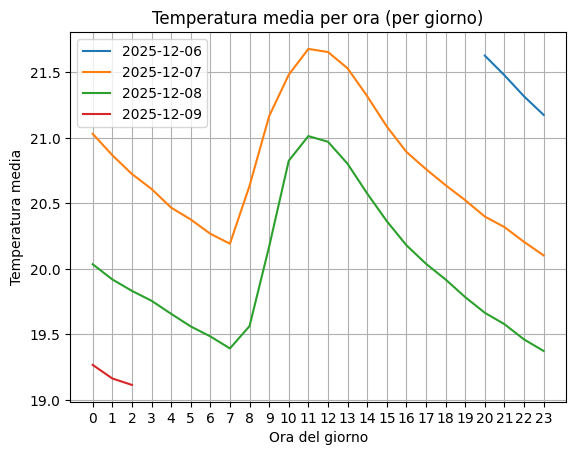

In [74]:
plt.figure()

for d, grp in pdf.groupby("date"):
    plt.plot(grp["hour_of_day"], grp["avg_temperature"], label=str(d.date()))

plt.xlabel("Ora del giorno")
plt.ylabel("Temperatura media")
plt.title("Temperatura media per ora (per giorno)")
plt.xticks(range(0, 24))
plt.legend()
plt.grid(True)
plt.show()

In [86]:
from pyspark.sql.functions import avg, min, max, stddev

df_hourly_global = df_hourly_avg.groupBy("hour_of_day").agg(
    avg("avg_temperature").alias("global_avg_temperature"),
    min("min_temperature").alias("global_min_temperature"),
    max("max_temperature").alias("global_max_temperature"),
    stddev("avg_temperature").alias("std_temperature")
)


In [87]:
pdf_global = df_hourly_global.orderBy("hour_of_day").toPandas()

In [88]:
pdf_global["std_plus"]  = pdf_global["global_avg_temperature"] + pdf_global["std_temperature"]
pdf_global["std_minus"] = pdf_global["global_avg_temperature"] - pdf_global["std_temperature"]


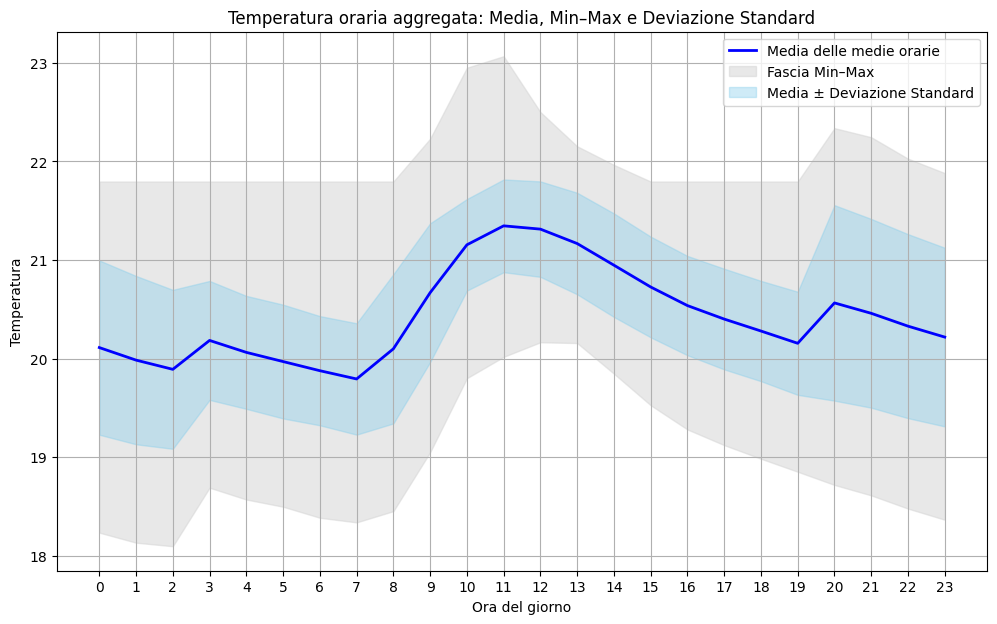

In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))

# linea principale: media delle medie
plt.plot(
    pdf_global["hour_of_day"],
    pdf_global["global_avg_temperature"],
    color="blue",
    label="Media delle medie orarie",
    linewidth=2
)

# fascia min–max
plt.fill_between(
    pdf_global["hour_of_day"],
    pdf_global["global_min_temperature"],
    pdf_global["global_max_temperature"],
    color="lightgray",
    alpha=0.5,
    label="Fascia Min–Max"
)

# fascia mean ± stddev
plt.fill_between(
    pdf_global["hour_of_day"],
    pdf_global["std_minus"],
    pdf_global["std_plus"],
    color="skyblue",
    alpha=0.4,
    label="Media ± Deviazione Standard"
)

plt.xlabel("Ora del giorno")
plt.ylabel("Temperatura")
plt.title("Temperatura oraria aggregata: Media, Min–Max e Deviazione Standard")
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend()
plt.show()
